# Install and Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import pickle

warnings.filterwarnings('ignore')

# Load data

In [2]:
df = pd.read_csv('../unesco-challenge-corals-distribution/dataset/data.csv')
df.shape

(2471, 10)

# Descriptive Analysis

In [3]:
df.head()

name   salinity  January_temp  June_temp    area  latitude  \
0  Adriatic Sea  38.298527     15.658799  20.855299  138000        43   
1  Adriatic Sea  38.304909     16.297098  19.501200  138000        43   
2  Adriatic Sea  38.462040     16.251598  19.028500  138000        43   
3  Adriatic Sea  38.121601     15.709500  22.882999  138000        43   
4  Adriatic Sea  38.519196     15.733400  21.824799  138000        43   

   longitude  type of sea  corals  silt/sulfide  
0         15            2       1             0  
1         15            2       1             0  
2         15            2       1             0  
3         15            2       1             0  
4         15            2       1             0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2471 non-null   object 
 1   salinity      2471 non-null   float64
 2   January_temp  2471 non-null   float64
 3   June_temp     2471 non-null   float64
 4   area          2471 non-null   int64  
 5   latitude      2471 non-null   int64  
 6   longitude     2471 non-null   int64  
 7   type of sea   2471 non-null   int64  
 8   corals        2471 non-null   int64  
 9   silt/sulfide  2471 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 193.2+ KB


## Numerical features

In [5]:
df.describe().T

count          mean           std           min            25%  \
salinity      2471.0  3.281795e+01  6.620384e+00      5.933204      32.874348   
January_temp  2471.0  1.792853e+01  1.111731e+01     -1.899994       7.890149   
June_temp     2471.0  2.153131e+01  1.014451e+01     -1.899994      19.000000   
area          2471.0  1.006533e+06  1.207700e+06  11500.000000  280000.000000   
latitude      2471.0  1.778066e+01  3.410340e+01    -75.000000      -5.000000   
longitude     2471.0  7.685714e+01  5.499335e+01   -178.000000      28.000000   
type of sea   2471.0  2.681505e+00  5.075721e-01      1.000000       2.000000   
corals        2471.0  8.530959e-01  3.540819e-01      0.000000       1.000000   
silt/sulfide  2471.0  4.937272e-02  2.258376e-01      0.000000       0.000000   

                        50%           75%           max  
salinity          34.191502  3.613582e+01  4.000000e+01  
January_temp      19.497200  2.822470e+01  3.076350e+01  
June_temp         24.600000  2.961455e+01  3.230000e+01  
area          610000.000000  1.150000e+06  5.695000e+06  
latitude          22.000000  4.000000e+01  7.700000e+01  
longitude         65.000000  1.250000e+02  1.630000e+02  
type of sea        3.000000  3.000000e+00  4.000000e+00  
corals             1.000000  1.000000e+00  1.000000e+00  
silt/sulfide       0.000000  0.000000e+00  2.000000e+00

## Categorical features

In [6]:
df.describe(include=object).T

count unique           top freq
name  2471     70  Adriatic Sea   49

## NaN analysis

In [7]:
df.isnull().sum()

name            0
salinity        0
January_temp    0
June_temp       0
area            0
latitude        0
longitude       0
type of sea     0
corals          0
silt/sulfide    0
dtype: int64

## Duplicated values

In [8]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis

## Number of seas

In [9]:
print('Number of seas in dataset:', df['name'].nunique())

Number of seas in dataset: 70


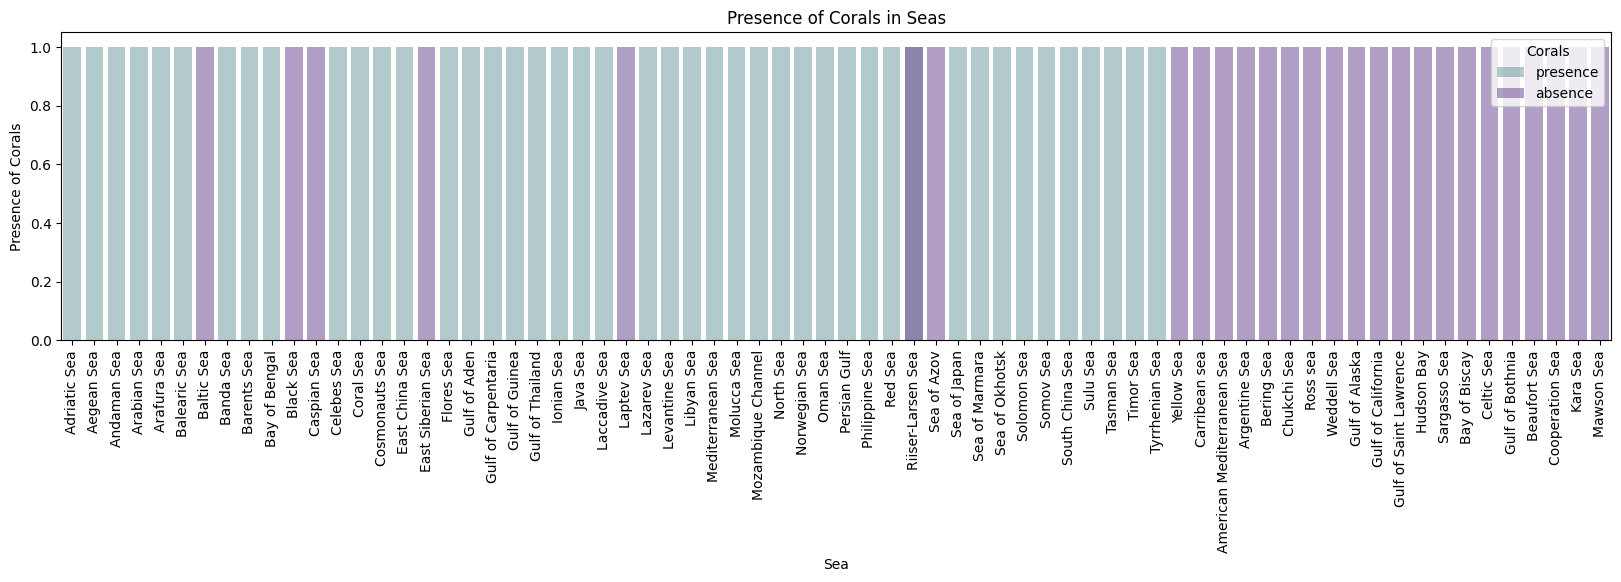

In [10]:
plt.figure(figsize=(20, 4))
sns.barplot(x='name', y=1, data=df.assign(Corals=df['corals'].map({0:'absence',1:'presence'})), hue='Corals', dodge=False, palette=({'presence':'cadetblue','absence':'rebeccapurple'}), alpha=0.5)

plt.xlabel('Sea')
plt.ylabel('Presence of Corals')
plt.title('Presence of Corals in Seas')
plt.xticks(rotation=90)

plt.show()

In [11]:
seas_corals = df.groupby('name')['corals'].nunique()
seas_corals[seas_corals > 1].reset_index()

name  corals
0  Riiser-Larsen Sea       2

The Riiser-Larsen Sea is a marginal sea of the Southern Ocean and the only sea among the 70 in the dataset that has a presence/absence of corals.

In [12]:
df[df['name'].eq('Riiser-Larsen Sea')]

name   salinity  January_temp  June_temp     area  \
1862  Riiser-Larsen Sea  33.884373       -0.4713  -1.899994  1138000   
2470  Riiser-Larsen Sea  33.990000        0.1600  -1.890000  1138000   

      latitude  longitude  type of sea  corals  silt/sulfide  
1862       -68         22            3       1             0  
2470       -68         22            3       0             2

In [13]:
round(df['silt/sulfide'].value_counts(normalize=True)*100,2)

0    95.27
1     4.53
2     0.20
Name: silt/sulfide, dtype: float64

Based on the data above, the only significant difference leading to the absence of corals in this sea is the value 2 for silt/sulfide. A hypothesis that still needs to be validated is whether the presence of silt/sulfide is equivalent to the absence of corals.

The data dictionary indicates that:

- 0 indicates absence of silt/sulfide
- 1 indicates presence of silt/sulfide

 I am assuming that value "2" means no clear information. Since this represents 0.20% of the total, these values will be dropped.

In [14]:
df[df['silt/sulfide'].eq(2)]

name  salinity  January_temp  June_temp     area  latitude  \
2466       Beaufort Sea     30.00         -1.80      -1.40   476000        72   
2467    Cooperation Sea     33.62          0.12      -1.89   258000       -65   
2468           Kara Sea     27.76         -1.89       6.90   926000        77   
2469         Mawson Sea     33.98         -1.50      -1.89   333000       -65   
2470  Riiser-Larsen Sea     33.99          0.16      -1.89  1138000       -68   

      longitude  type of sea  corals  silt/sulfide  
2466       -137            3       0             2  
2467         72            3       0             2  
2468         77            3       0             2  
2469        105            3       0             2  
2470         22            3       0             2

In [15]:
print('Dataframe shape before drop value "2" of silt/sulfide:', df.shape[0])

df = df[~df['silt/sulfide'].eq(2)]

print('Dataframe shape after drop value "2" of silt/sulfide:', df.shape[0])

Dataframe shape before drop value "2" of silt/sulfide: 2471
Dataframe shape after drop value "2" of silt/sulfide: 2466


## Type of seas

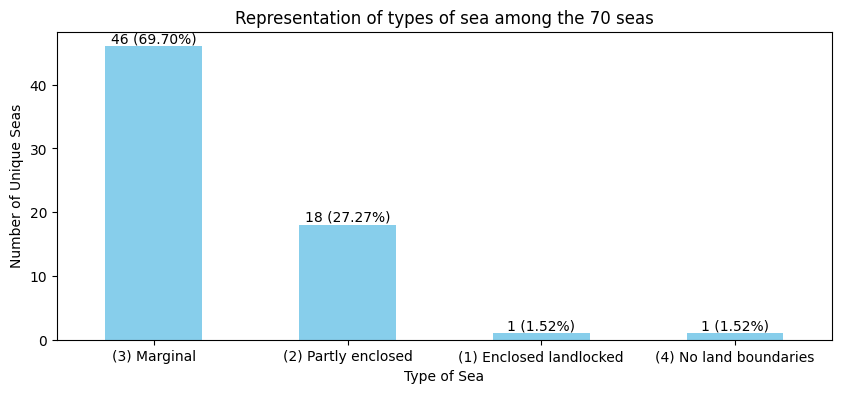

In [16]:
unique_seas = df.groupby('type of sea')['name'].nunique().sort_values(ascending=False)

percentages = (unique_seas / unique_seas.sum()) * 100

plt.figure(figsize=(10, 4))
unique_seas.plot(kind='bar', color='skyblue')
plt.xlabel('Type of Sea')
plt.ylabel('Number of Unique Seas')
plt.title(f'Representation of types of sea among the 70 seas')
plt.xticks(rotation=0)

ax = plt.gca()
type_mapping = {
    1: '(1) Enclosed landlocked',
    2: '(2) Partly enclosed',
    3: '(3) Marginal',
    4: '(4) No land boundaries'
}

ax.set_xticklabels([type_mapping.get(i, str(i)) for i in unique_seas.index])

for i, (v, p) in enumerate(zip(unique_seas, percentages)):
    plt.text(i, v + 0.1, f'{v} ({p:.2f}%)', ha='center', va='bottom')

plt.show()

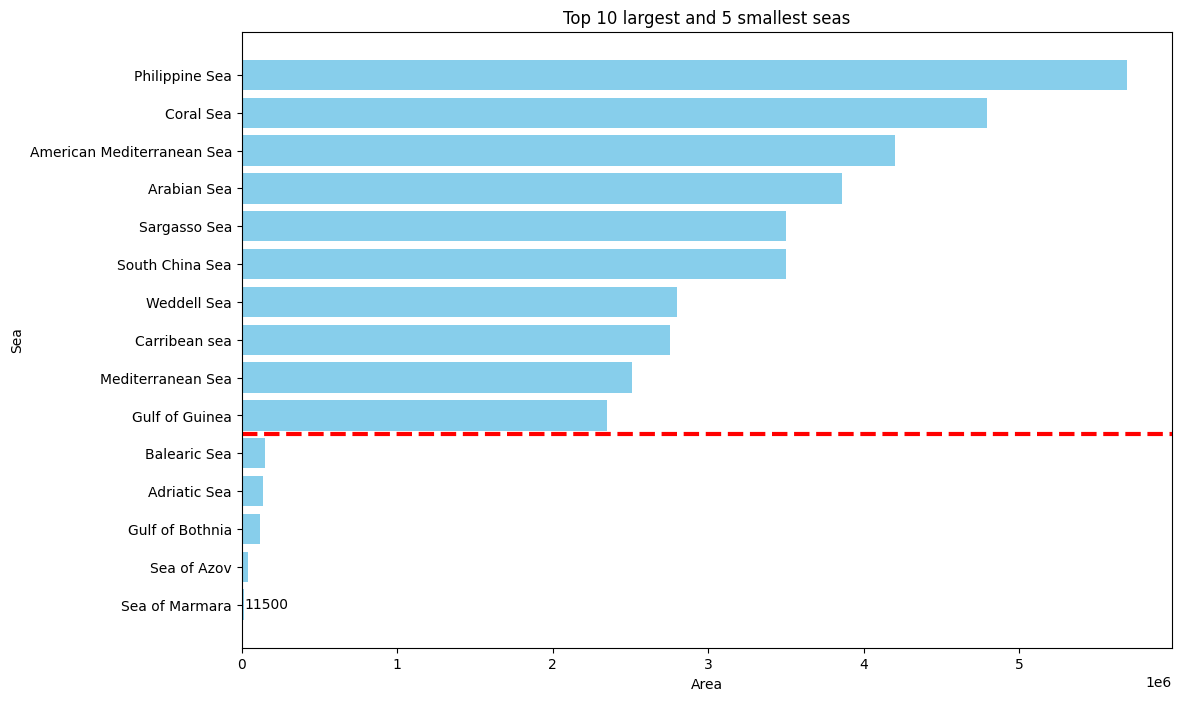

In [17]:
df_sea_areas = df.groupby('name', as_index=False).max().sort_values(by='area',ascending=False)

df_top_10_largest_sea = df_sea_areas.head(10)
df_top_10_smallest_sea = df_sea_areas.tail(5)

df_graph_sea_area = pd.concat([df_top_10_largest_sea, df_top_10_smallest_sea])

df_graph_sea_area = df_graph_sea_area.sort_values(by='area', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(df_graph_sea_area['name'], df_graph_sea_area['area'], color='skyblue')
plt.xlabel('Area')
plt.ylabel('Sea')
plt.title('Top 10 largest and 5 smallest seas')

sep_index = len(df_top_10_smallest_sea)
plt.axhline(y=sep_index - 0.5, color='red', linestyle='--', linewidth= 3)

min_area_value = df_graph_sea_area['area'].iloc[0]
min_area_name = df_graph_sea_area['name'].iloc[0]
plt.text(min_area_value + 5000, 0, f'{min_area_value}', va='center')

plt.show()

In [18]:
print(f"{df_graph_sea_area['name'].iloc[-1]} occupies the first position as the biggest sea with an area of {max(df_graph_sea_area['area'])} square kilometers and the smallest one is {df_graph_sea_area['name'].iloc[0]} ({min(df_graph_sea_area['area'])} square kilometers).")

Philippine Sea occupies the first position as the biggest sea with an area of 5695000 square kilometers and the smallest one is Sea of Marmara (11500 square kilometers).


## Temperature

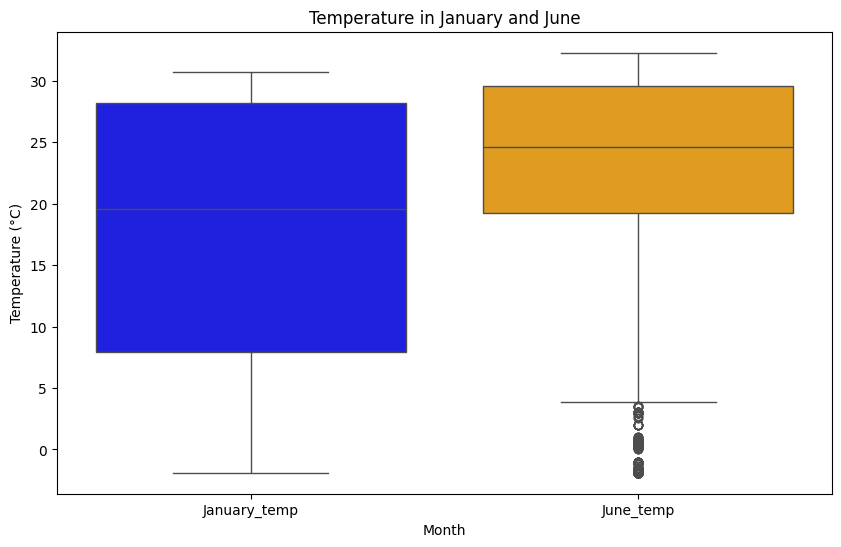

In [19]:
df_melted = df.melt(value_vars=['January_temp', 'June_temp'], var_name='Month', value_name='Temperature')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Temperature', data=df_melted, palette=['blue', 'orange'])
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature in January and June')

plt.show()

This is a particular case where removing the June outliers is not applicable, as various regions of the world are being considered, and temperatures can vary to extremes values.

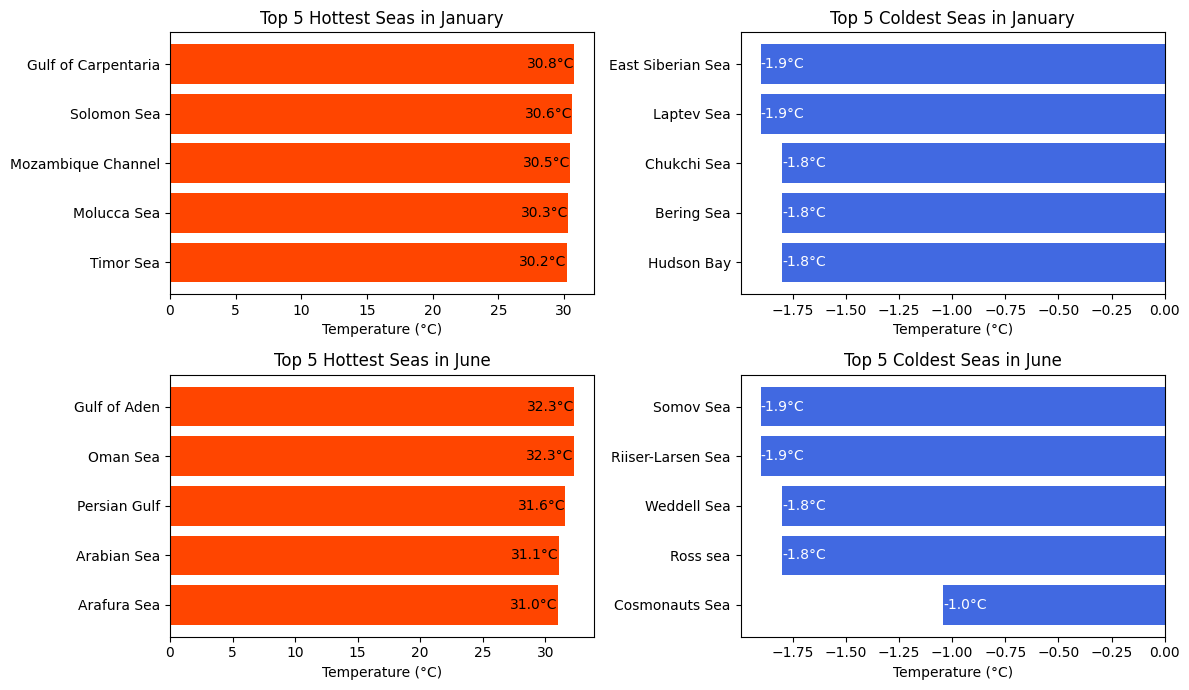

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

hottest_jan = df.groupby('name', as_index=False).max().sort_values(by='January_temp', ascending=False).head(5)
coldest_jan = df.groupby('name', as_index=False).max().sort_values(by='January_temp', ascending=False).tail(5)
hottest_june = df.groupby('name', as_index=False).max().sort_values(by='June_temp', ascending=False).head(5)
coldest_june = df.groupby('name', as_index=False).max().sort_values(by='June_temp', ascending=False).tail(5)

axs[0, 0].barh(hottest_jan['name'], hottest_jan['January_temp'], color='orangered')
axs[0, 0].set_title('Top 5 Hottest Seas in January')
axs[0, 0].set_xlabel('Temperature (°C)')
axs[0, 0].invert_yaxis()
for i, v in enumerate(hottest_jan['January_temp']):
    axs[0, 0].text(v, i, str(round(v,1))+'°C', color='black', va='center', horizontalalignment='right')

axs[0, 1].barh(coldest_jan['name'], coldest_jan['January_temp'], color='royalblue')
axs[0, 1].set_title('Top 5 Coldest Seas in January')
axs[0, 1].set_xlabel('Temperature (°C)')
for i, v in enumerate(coldest_jan['January_temp']):
    axs[0, 1].text(v, i, str(round(v,1))+'°C', color='white', va='center', horizontalalignment='left')

axs[1, 0].barh(hottest_june['name'], hottest_june['June_temp'], color='orangered')
axs[1, 0].set_title('Top 5 Hottest Seas in June')
axs[1, 0].set_xlabel('Temperature (°C)')
axs[1, 0].invert_yaxis()
for i, v in enumerate(hottest_june['June_temp']):
    axs[1, 0].text(v, i, str(round(v,1))+'°C', color='black', va='center', horizontalalignment='right')

axs[1, 1].barh(coldest_june['name'], coldest_june['June_temp'], color='royalblue')
axs[1, 1].set_title('Top 5 Coldest Seas in June')
axs[1, 1].set_xlabel('Temperature (°C)')
for i, v in enumerate(coldest_june['June_temp']):
    axs[1, 1].text(v, i, str(round(v,1))+'°C', color='white', va='center', horizontalalignment='left')

plt.tight_layout()
plt.show()

## Representation of target "corals" for each variable

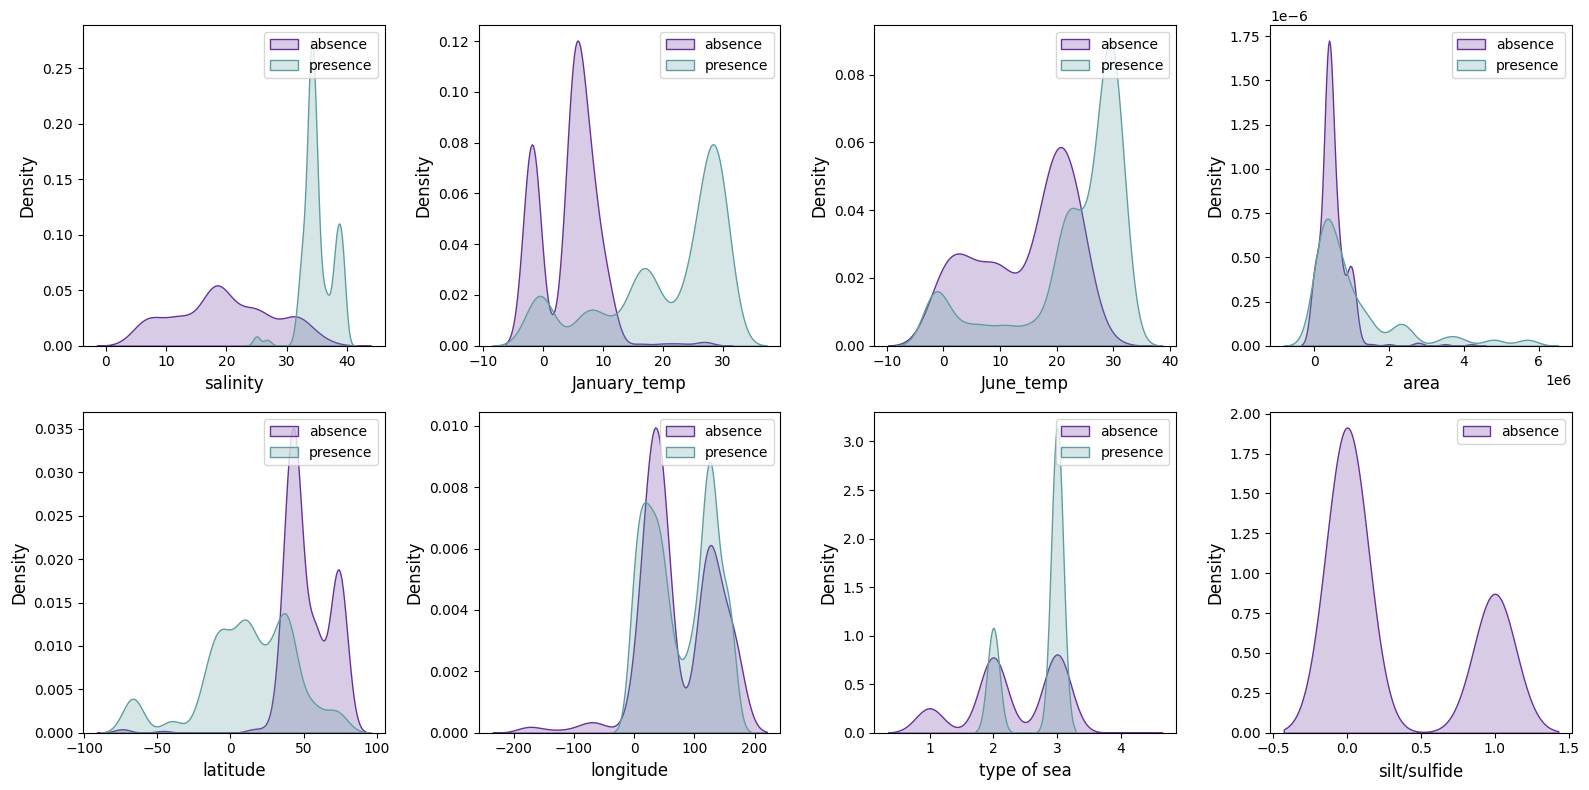

In [21]:
corals_0 = df[df['corals'] == 0]
corals_1 = df[df['corals'] == 1]

columns = ['salinity','January_temp','June_temp', 
            'area','latitude','longitude', 
            'type of sea','silt/sulfide']

num_plots = len(columns)
num_rows = num_plots // 4 + (num_plots % 4 > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows*4))

for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax = sns.kdeplot(
        corals_0[column], 
        color='rebeccapurple', 
        label='absence', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax = sns.kdeplot(
        corals_1[column], 
        color='cadetblue', 
        label='presence', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax.legend()
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)

if num_plots < num_rows * 4:
    for i in range(num_plots, num_rows * 4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()

- Salinity emerges as the most crucial factor in differentiating areas suitable for coral habitation from those where corals cannot thrive. This observation is supported not only by our dataset but also by scientific research, which highlights salinity as a critical factor for coral survival, particularly during times of global warming;

- The presence of silt or sulfide on the sea bottom or in the water makes coral existence impossible. This phenomenon is evident, for example, in the case of the Yellow Sea, where water is heavily laden with silt from rivers. Therefore, silt or sulfide content is a significant feature that characterizes only 'non-coral' areas;

- Enclosed landlocked seas mentioned in this dataset are not the dwellings for corals;

- Surprizingly, both January temperature and latitude (!) can play a role in distinguishing between 'coral' and 'non-coral' seas.

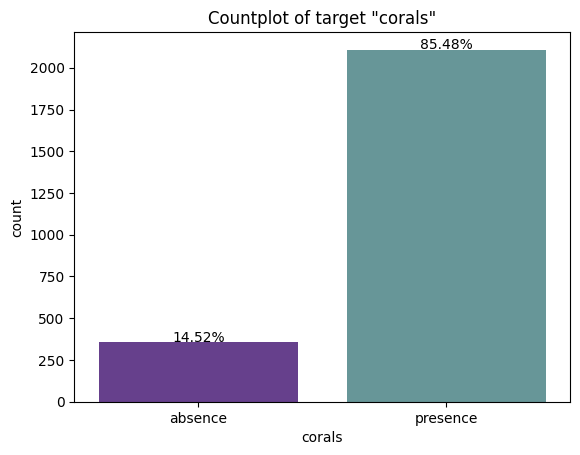

In [22]:
ax = sns.countplot(x='corals', data=df, palette=({'1':'cadetblue','0':'rebeccapurple'}))

total = len(df['corals'])

presence_mapping = {
    0: 'absence',
    1: 'presence'
}

ax.set_xticklabels([presence_mapping.get(i, str(i)) for i in df.index])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")

plt.title('Countplot of target "corals"')
plt.show()

Due to the target's imbalance, I will balance it later using the SMOTE method. When distinguishing the most important features by type ('coral' or 'non-coral'), it becomes evident that:

- 'non-coral' areas are characterized by narrow range of January temperatures and low salinity in majority of cases;
- in contrast, areas inhabited by corals show wide range of January temperatures and salinity not less than 24-25 PSU.

In [23]:
f = folium.Figure(width=1200, height=600)

m = folium.Map(location=[41, 12], tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
               attr = 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
               zoom_start=2).add_to(f)

# Choose the colors for the markers
def color_maker(status):
    if status == 0:
        return 'purple'
    elif status == 1:
        return 'green'
    else:
        return 'black'
    
# Add markers with colors
for _, row in df.iterrows():
    status = row['corals']
    color = color_maker(status)
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
        '{}, salinity: {:.2f} PSU, silt/sulfide: {}, area: {} sq km, '
        'January temperature: {:.2f}°C, June temperature: {:.2f}°C'
        .format(
            row['name'],
            row['salinity'],
            row['silt/sulfide'],
            row['area'],
            row['January_temp'],
            row['June_temp']
            )
        ),
        icon=folium.Icon(icon = 'sun', prefix='fa', color=color)
    ).add_to(m)
    
# Legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 100px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 opacity: 0.8;
                 ">
        
        <p><b><i class="fa fa-map-marker fa-1x" style="color: purple"></i> - Absence of corals<b></p>
        <p><i class="fa fa-map-marker fa-1x" style="color: green"></i> - Presence of corals</p>
        <p><i class="fa fa-map-marker fa-1x" style="color: black"></i> - No clear info</p>
    </div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

m

To iteract with the dynamic map, please check this notebook at https://nbviewer.org/github/guilhermegarcia-ai/ml-classification-models/blob/main/unesco-challenge-corals-distribution/unesco_corals_distribution_classification.ipynb.

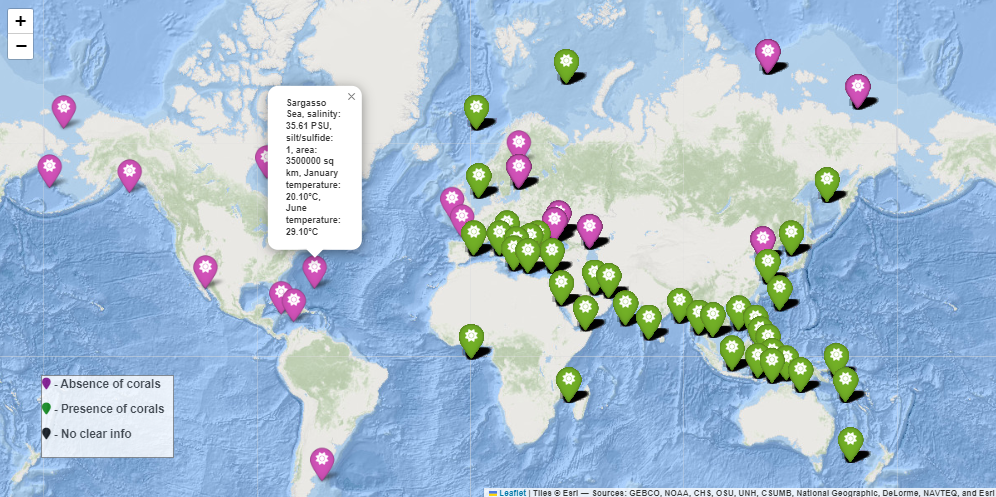

## Correlation

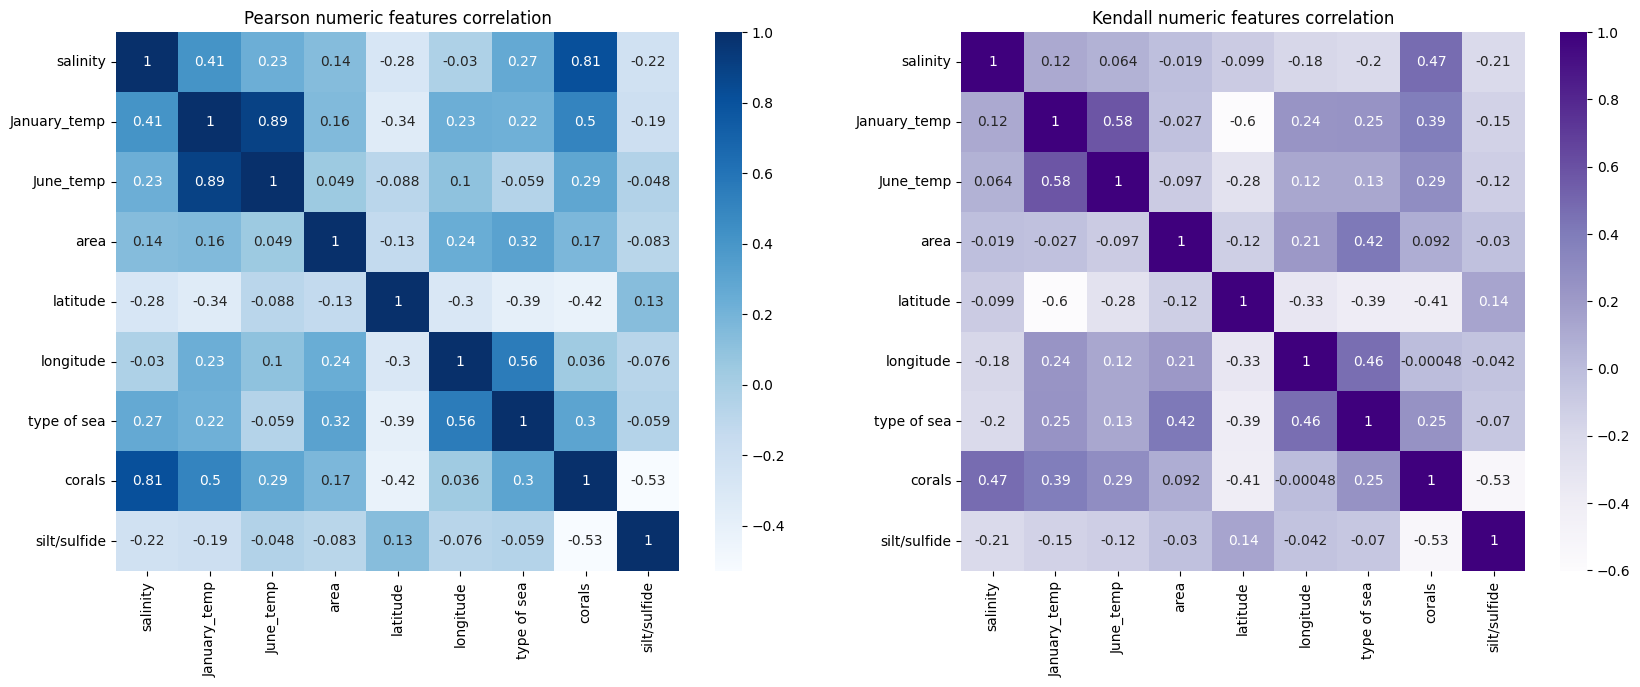

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(df.corr(), annot=True, cmap='Blues', ax=axs[0])
axs[0].set_title('Pearson numeric features correlation')

sns.heatmap(df.corr(method='kendall'), annot=True, cmap='Purples', ax=axs[1])
axs[1].set_title('Kendall numeric features correlation')

plt.show()

Considering the Pearson matrix, it is possible to see that the target value is strongly correlated with salinity of seas (0.81), temperatures in January (0.5), specification of bottom silt/sulfide (-0.53) and latitude (-0.42).

# Feature Engineering

## Train test split

In [25]:
df_train_test = df.sample(frac= 0.95, random_state=42)
df_validate = df.drop(df_train_test.index)

df_train_test.reset_index(drop=True, inplace= True)
df_validate.reset_index(drop=True, inplace= True)

print('95% of data for modeling:', df_train_test.shape)
print('05% of data for validate:', df_validate.shape)

95% of data for modeling: (2343, 10)
05% of data for validate: (123, 10)


In [26]:
X = df_train_test.drop(columns=['name','corals'])
y = df_train_test['corals']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1874, 8)
(1874,)
(469, 8)
(469,)


## Data Scaling

In [28]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [29]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head(2)

salinity  January_temp  June_temp      area  latitude  longitude  \
0 -2.304322     -1.063061  -0.187675 -0.798455  0.827666  -0.732397   
1 -0.216332     -0.888074  -0.338936 -0.522202  0.590430   0.848351   

   type of sea  silt/sulfide  
0    -1.329288     -0.217974  
1     0.629113      4.587707

## Data Balancing

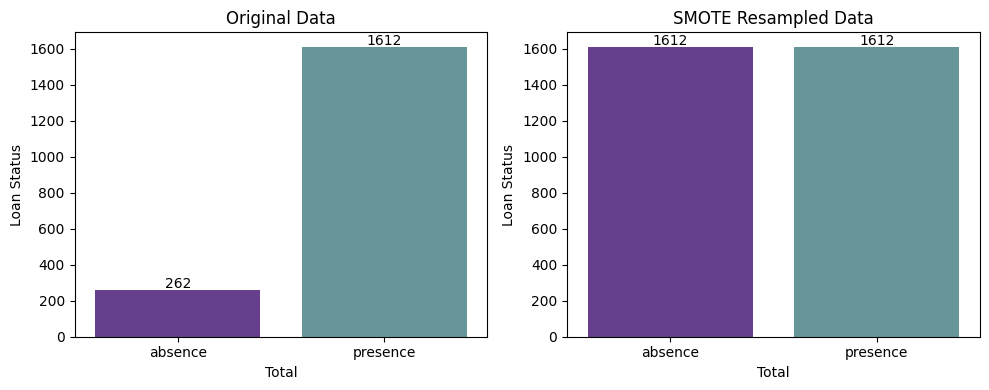

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x='corals', data=pd.DataFrame(y_train), palette=({'1':'cadetblue','0':'rebeccapurple'}), ax=axs[0])
axs[0].set_ylabel('Loan Status')
axs[0].set_xlabel('Total')
axs[0].set_title('Original Data')
axs[0].set_xticklabels([presence_mapping.get(i, str(i)) for i in df.index])

for p in axs[0].patches:
    axs[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center_baseline',
                 xytext=(0, 5), textcoords='offset points', fontsize=10)


X_train_res, y_train_res = SMOTE().fit_resample(X_train_scaled, y_train)

sns.countplot(x='corals', data=pd.DataFrame(y_train_res), palette=({'1':'cadetblue','0':'rebeccapurple'}), ax=axs[1])
axs[1].set_ylabel('Loan Status')
axs[1].set_xlabel('Total')
axs[1].set_title('SMOTE Resampled Data')
axs[1].set_xticklabels([presence_mapping.get(i, str(i)) for i in df.index])
for p in axs[1].patches:
    axs[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center_baseline',
                 xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

In [31]:
print('Original Training Data:')
print(X_train_scaled.shape)
print(y_train.shape)

print('\nSMOTE Resampled Training Data:')
print(X_train_res.shape)
print(y_train_res.shape)

Original Training Data:
(1874, 8)
(1874,)

SMOTE Resampled Training Data:
(3224, 8)
(3224,)


# Predictive Model

## Training models with cross validation

In [32]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter = 3000)),
    ('SVC', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('Gradient Boosting Classifier', GradientBoostingClassifier()),
    ('LGBMClassifier', LGBMClassifier(verbose=-1)),
    ('XGBoost Classifier', XGBClassifier()),
    ('AdaBoost Classifier', AdaBoostClassifier())
    ]

cross_val_metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# List to store model results and the models themselves
results = []
models_func = []

for name, model in models:
    # Append the model to the models list
    models_func.append(model)

    # Dictionary to store model results
    model_results = {
        'model':name,
        'approach':'all features'
    }

    # Train models
    model.fit(X_train_res, y_train_res)

    # Perform cross-validation to calculate evaluation metrics
    cross_val_scores = cross_validate(
        model,
        X_train_res,
        y_train_res,
        cv=5, # Using the default 5-fold cross validation
        scoring=cross_val_metrics
    )

    for metric in cross_val_metrics:
        key = 'test_' + metric
        model_results[metric] = round(cross_val_scores[key].mean(),3) # Collecting the mean of 5 folds for each metric

    results.append(model_results)

In [33]:
df_model_comparison = pd.DataFrame(results)

df_model_comparison.sort_values(by='recall',ascending=False)

model      approach  roc_auc  accuracy  precision  \
0           Logistic Regression  all features      1.0      1.00      1.000   
1                           SVC  all features      1.0      1.00      1.000   
2                   Naive Bayes  all features      1.0      0.95      0.909   
3           K-Nearest Neighbors  all features      1.0      1.00      1.000   
4      Decision Tree Classifier  all features      1.0      1.00      1.000   
5      Random Forest Classifier  all features      1.0      1.00      1.000   
6  Gradient Boosting Classifier  all features      1.0      1.00      1.000   
7                LGBMClassifier  all features      1.0      1.00      1.000   
8            XGBoost Classifier  all features      1.0      1.00      1.000   
9           AdaBoost Classifier  all features      1.0      1.00      1.000   

   recall     f1  
0     1.0  1.000  
1     1.0  1.000  
2     1.0  0.952  
3     1.0  1.000  
4     1.0  1.000  
5     1.0  1.000  
6     1.0  1.000  
7     1.0  1.000  
8     1.0  1.000  
9     1.0  1.000

### Feature Importance

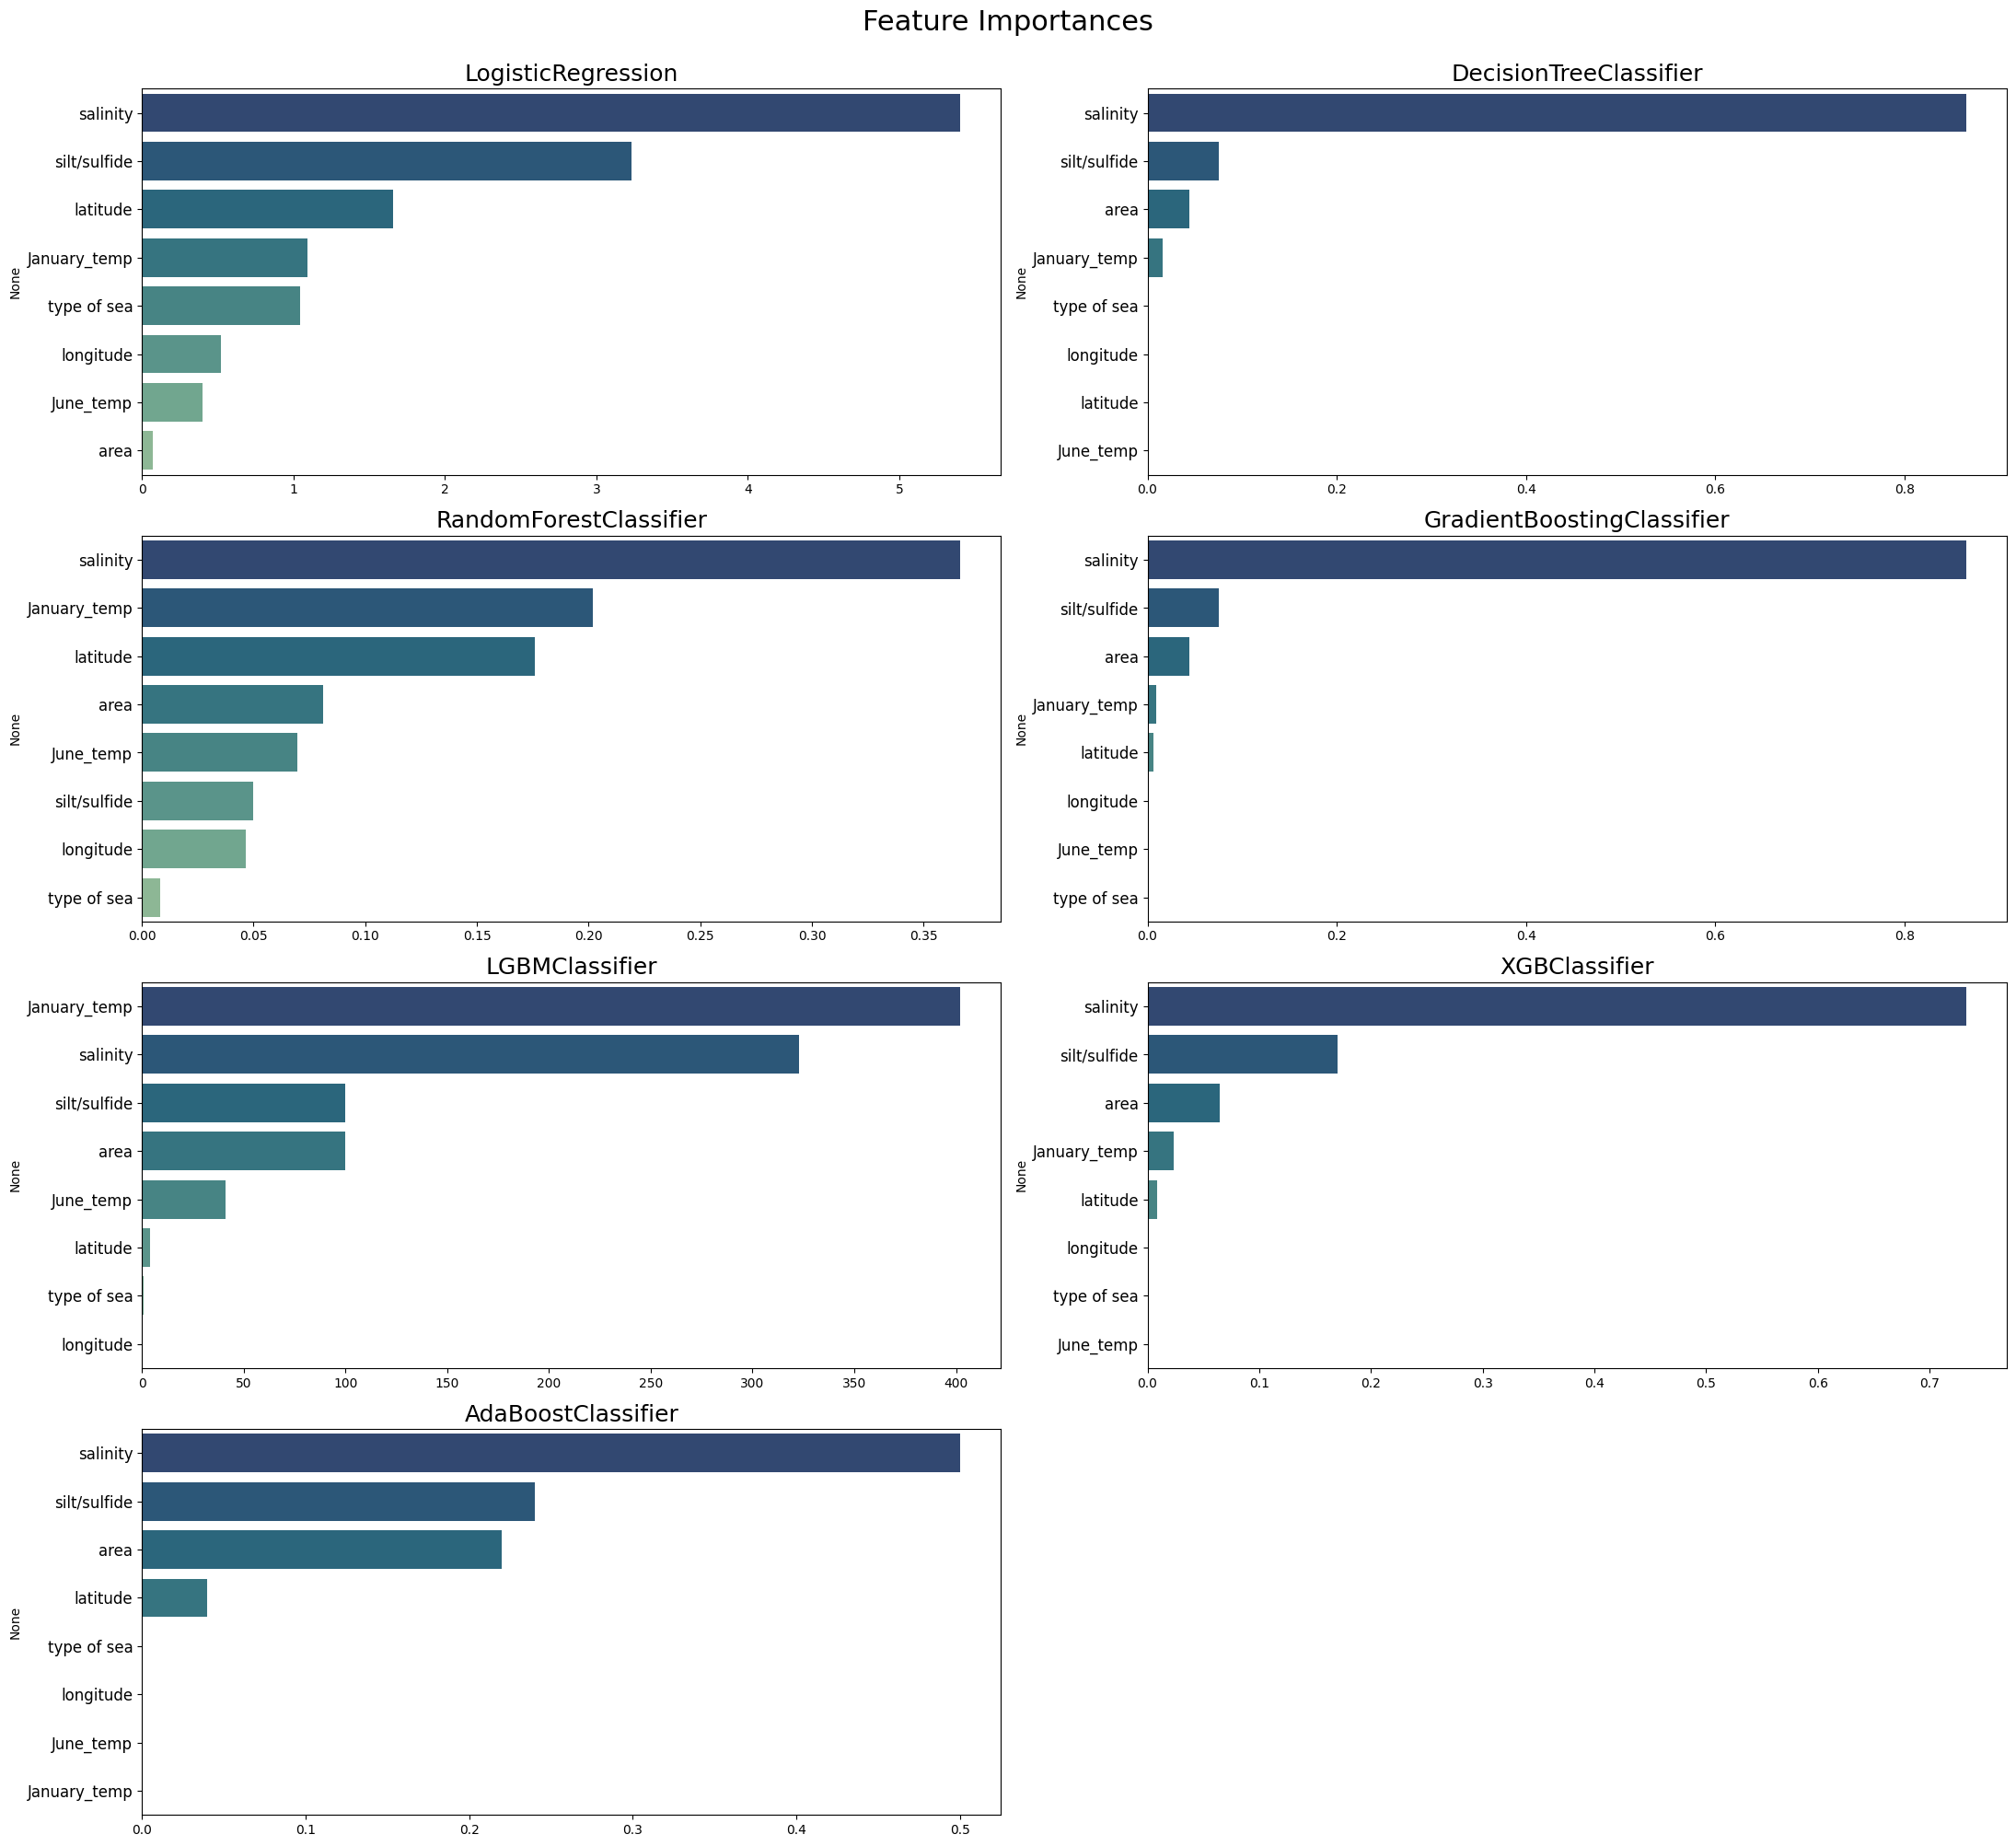

In [34]:
# Create a list of models, excluding SVC, GaussianNB, and KNeighborsClassifier
models_func = [clf for clf in models_func if type(clf) not in {SVC, GaussianNB, KNeighborsClassifier}]

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(len(models_func) + 1) // 2, ncols=2, figsize=(22, 20))
axes = axes.flatten()

# Iterate over each model and plot feature importances
for i, model in enumerate(models_func):
    model.fit(X_train_res, y_train_res)
    feature_importances = (np.abs(model.coef_[0]) if isinstance(model, LogisticRegression)
                           else model.feature_importances_)
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    sns.barplot(x=feature_importances[sorted_indices], 
                y=X_train.columns[sorted_indices], 
                ax=axes[i], 
                palette='crest_r')
    
    axes[i].set_title(model.__class__.__name__, fontsize=18)
    axes[i].tick_params(axis='y', labelsize=12)

# Remove any unused subplots
for ax in axes[len(models_func):]:
    fig.delaxes(ax)

# Add figure title
fig.suptitle('Feature Importances', fontsize=22, y=1)

plt.tight_layout()
plt.show()

## Training models with cross validation and reduced features

Analyzing the feature importance of the previous models, it's possible to observe that most of them can make decisions using only 4 features. These will be considered for a new training as a test: Salinity, Silt/Sulfide, Area, Latitude.

In [35]:
reducing_features = {'salinity':True,
                    'January_temp':True,
                    'June_temp':False,
                    'area':True,
                    'latitude':True,
                    'longitude':False,
                    'type of sea':False,
                    'silt/sulfide':True}

reduced_features_names = [col for col, value in reducing_features.items() if value]

In [36]:
X_train_res_reduced_features = X_train_res[:, list(reducing_features.values())]

In [37]:
pd.DataFrame(X_train_res_reduced_features, columns=reduced_features_names).head(1)

salinity  January_temp      area  latitude  silt/sulfide
0 -2.304322     -1.063061 -0.798455  0.827666     -0.217974

In [38]:
# List to store models
models_func = []

for name, model in models:
    # Append the model to the models list
    models_func.append(model)

    # Dictionary to store model results
    model_results = {
        'model':name,
        'approach':'reduced features'
    }

    # Train models
    model.fit(X_train_res_reduced_features, y_train_res)

    # Perform cross-validation to calculate evaluation metrics
    cross_val_scores = cross_validate(
        model,
        X_train_res_reduced_features,
        y_train_res,
        cv=5, # Using the default 5-fold cross validation
        scoring=cross_val_metrics
    )

    for metric in cross_val_metrics:
        key = 'test_' + metric
        model_results[metric] = round(cross_val_scores[key].mean(),3) # Collecting the mean of 5 folds for each metric

    results.append(model_results)

In [39]:
df_model_comparison = pd.DataFrame(results)

df_model_comparison.sort_values(by='recall',ascending=False).reset_index(drop=True)

model          approach  roc_auc  accuracy  \
0            Logistic Regression      all features      1.0     1.000   
1                            SVC      all features      1.0     1.000   
2             XGBoost Classifier  reduced features      1.0     1.000   
3                 LGBMClassifier  reduced features      1.0     1.000   
4   Gradient Boosting Classifier  reduced features      1.0     1.000   
5       Random Forest Classifier  reduced features      1.0     1.000   
6       Decision Tree Classifier  reduced features      1.0     1.000   
7            K-Nearest Neighbors  reduced features      1.0     1.000   
8                    Naive Bayes  reduced features      1.0     0.949   
9                            SVC  reduced features      1.0     1.000   
10           Logistic Regression  reduced features      1.0     1.000   
11           AdaBoost Classifier      all features      1.0     1.000   
12            XGBoost Classifier      all features      1.0     1.000   
13                LGBMClassifier      all features      1.0     1.000   
14  Gradient Boosting Classifier      all features      1.0     1.000   
15      Random Forest Classifier      all features      1.0     1.000   
16      Decision Tree Classifier      all features      1.0     1.000   
17           K-Nearest Neighbors      all features      1.0     1.000   
18                   Naive Bayes      all features      1.0     0.950   
19           AdaBoost Classifier  reduced features      1.0     1.000   

    precision  recall     f1  
0       1.000     1.0  1.000  
1       1.000     1.0  1.000  
2       1.000     1.0  1.000  
3       1.000     1.0  1.000  
4       1.000     1.0  1.000  
5       1.000     1.0  1.000  
6       1.000     1.0  1.000  
7       1.000     1.0  1.000  
8       0.907     1.0  0.951  
9       1.000     1.0  1.000  
10      1.000     1.0  1.000  
11      1.000     1.0  1.000  
12      1.000     1.0  1.000  
13      1.000     1.0  1.000  
14      1.000     1.0  1.000  
15      1.000     1.0  1.000  
16      1.000     1.0  1.000  
17      1.000     1.0  1.000  
18      0.909     1.0  0.952  
19      1.000     1.0  1.000

### Feature Importance

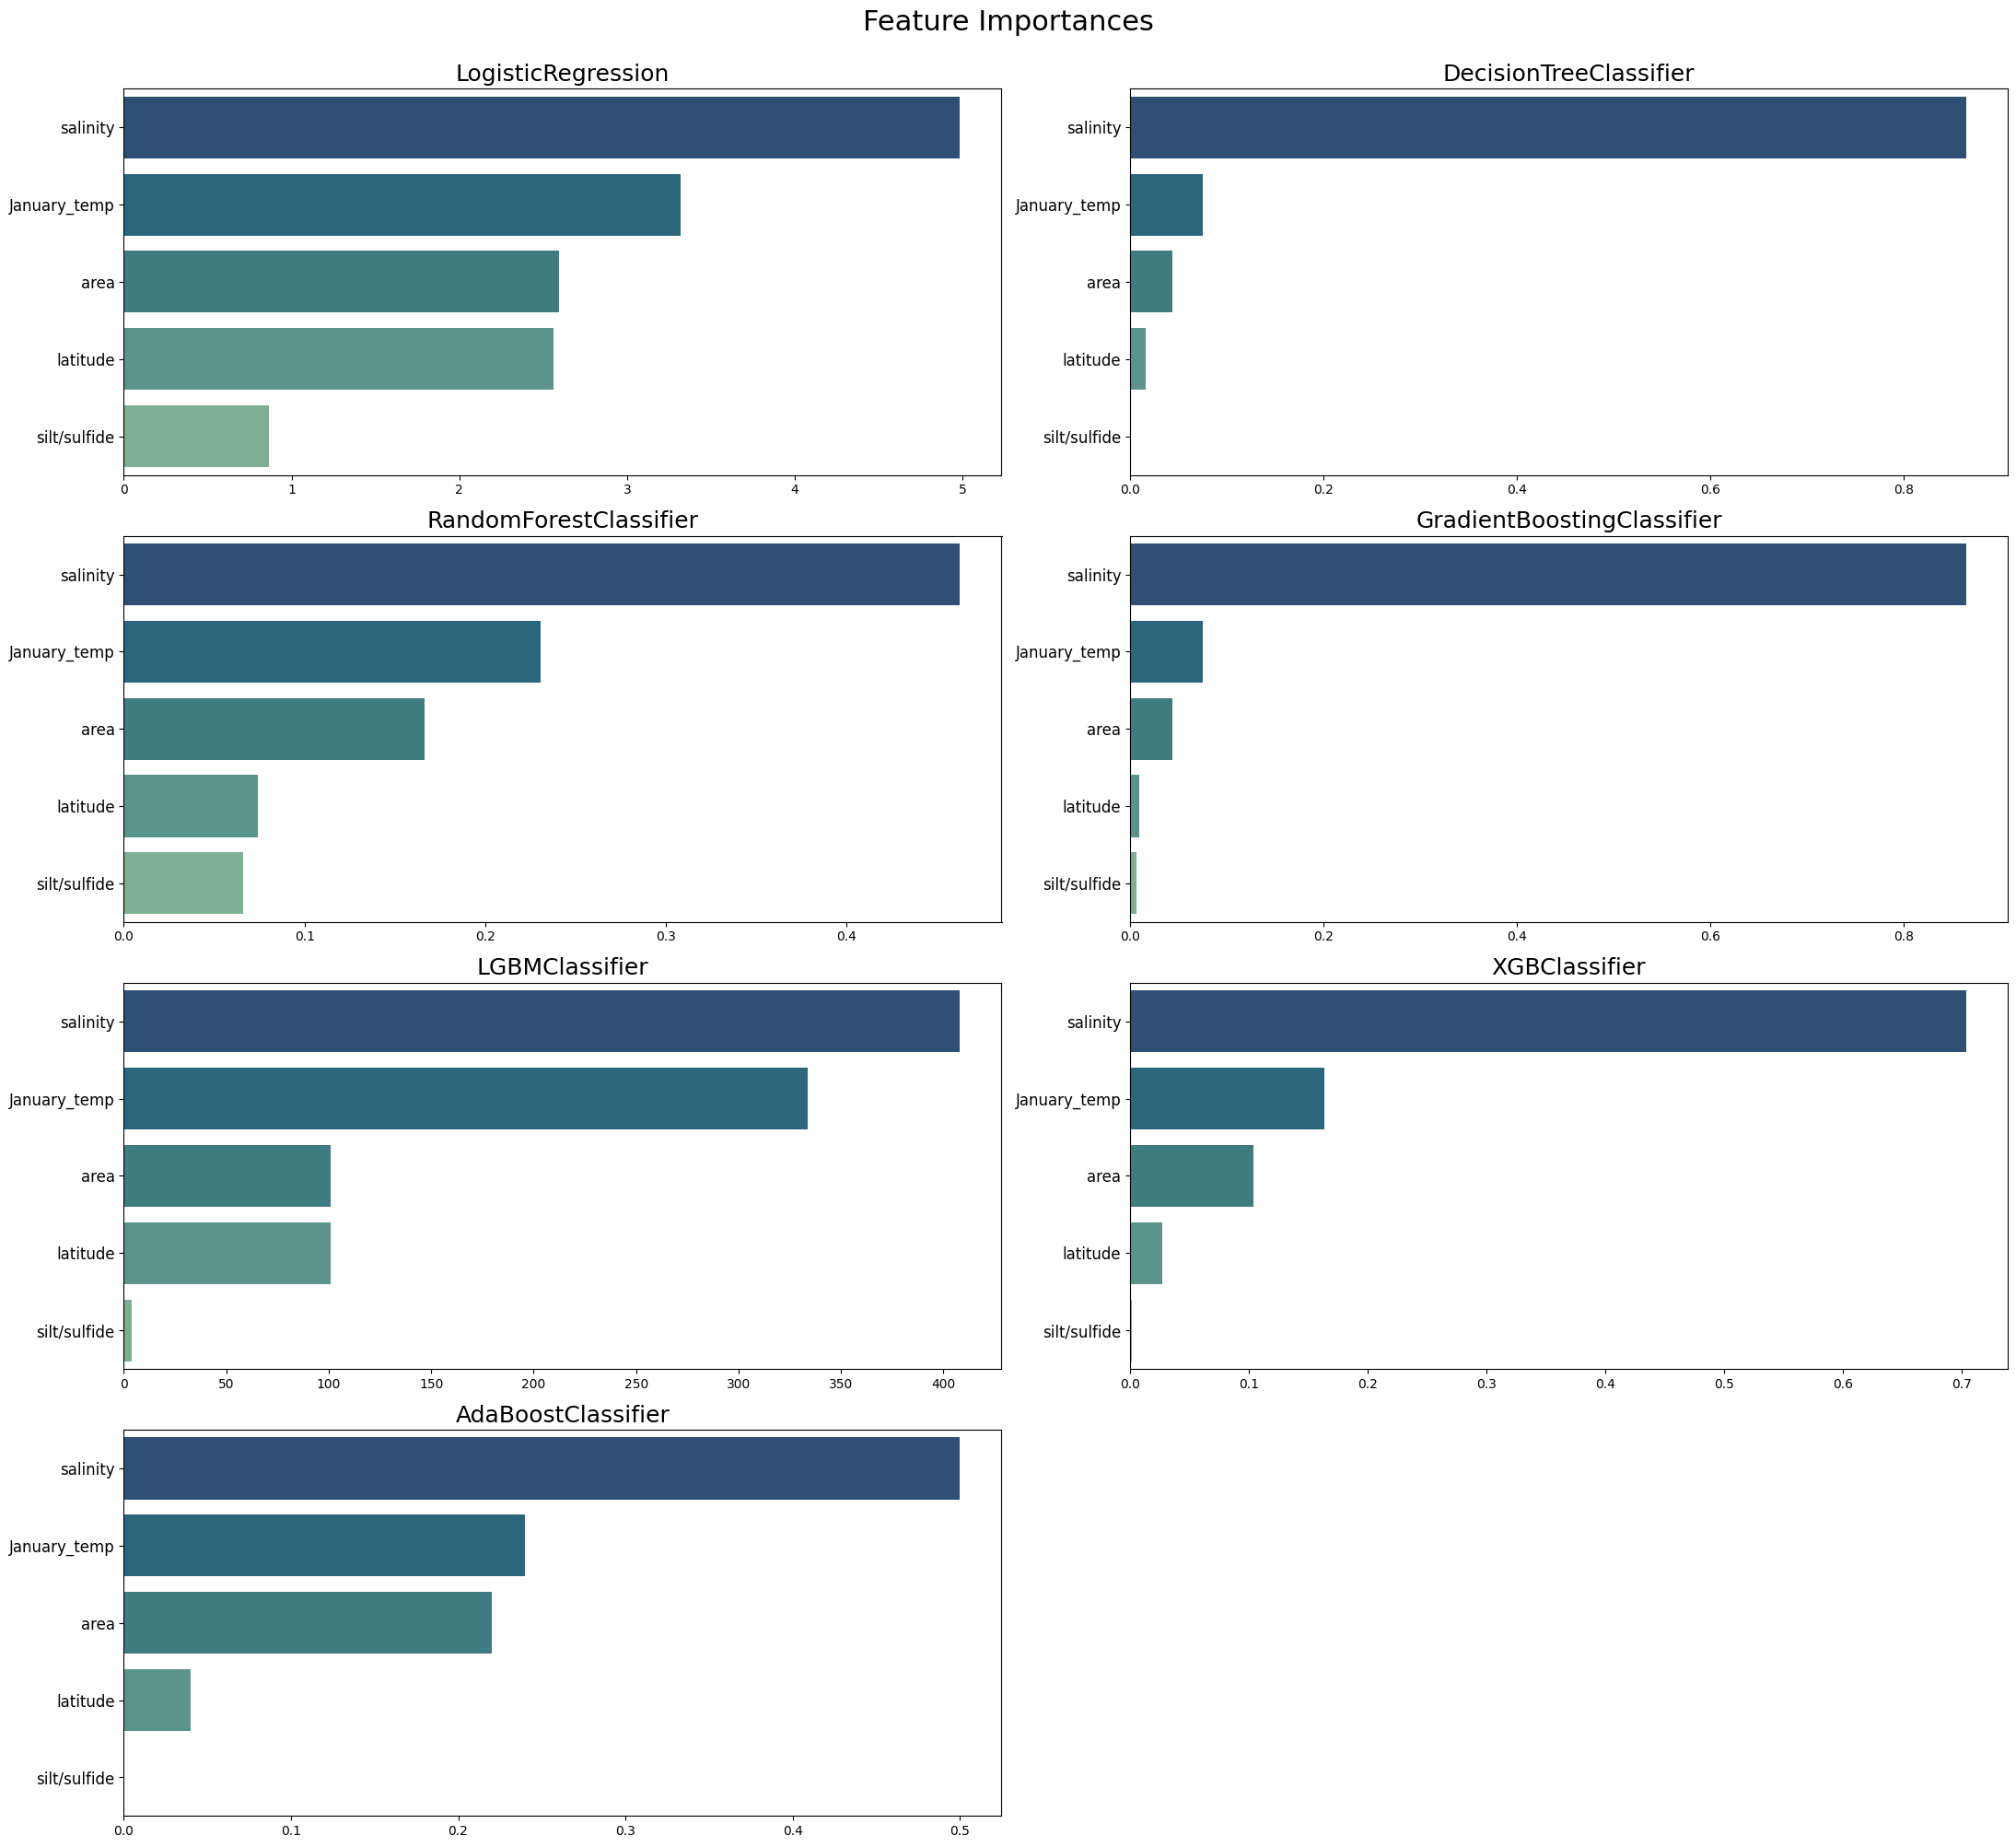

In [40]:
# Create a list of models, excluding SVC, GaussianNB, and KNeighborsClassifier
models_func = [clf for clf in models_func if type(clf) not in {SVC, GaussianNB, KNeighborsClassifier}]

# Create a grid of subplots
fig, axes = plt.subplots(nrows=(len(models_func) + 1) // 2, ncols=2, figsize=(22, 20))
axes = axes.flatten()

# Iterate over each model and plot feature importances
for i, model in enumerate(models_func):
    model.fit(X_train_res_reduced_features, y_train_res)
    feature_importances = (np.abs(model.coef_[0]) if isinstance(model, LogisticRegression)
                           else model.feature_importances_)
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    sns.barplot(x=feature_importances[sorted_indices], 
                y=reduced_features_names, 
                ax=axes[i], 
                palette='crest_r')
    
    axes[i].set_title(model.__class__.__name__, fontsize=18)
    axes[i].tick_params(axis='y', labelsize=12)

# Remove any unused subplots
for ax in axes[len(models_func):]:
    fig.delaxes(ax)

# Add figure title
fig.suptitle('Feature Importances', fontsize=22, y=1)

plt.tight_layout()
plt.show()

## Tunning best model

In [41]:
df_model_comparison[df_model_comparison['model'].eq('Logistic Regression') &
                    df_model_comparison['approach'].eq('reduced features')]

model          approach  roc_auc  accuracy  precision  \
10  Logistic Regression  reduced features      1.0       1.0        1.0   

    recall   f1  
10     1.0  1.0

After analyzing the models that are producing consistently high results in the evaluation metrics, the logistic regression model will be chosen for deployment. The main reasons contributing to this choice are:

- **Model Complexity**: Logistic Regression is a simpler model compared to others like XGBoost and Gradient Boosting. Its simplicity implies shorter training times and lower computational resource requirements during inference, ensuring computational efficiency.

- **Interpretability**: Logistic Regression is highly interpretable. Its coefficients directly indicate the impact of each feature on the predicted outcome, making it easier to understand and explain to stakeholders.

- **Robustness**: While Logistic Regression may not handle complex relationships as well as tree-based models, it still performs adequately in scenarios like this one. Its simplicity can actually be an advantage when dealing with straightforward relationships in the data.

- **Ease of Maintenance**: Logistic Regression models are relatively easy to maintain over time. They typically require less tuning and monitoring compared to more complex models, reducing the maintenance burden.

- **Scalability**: Logistic Regression scales well with increasing data volume. It doesn't suffer from significant performance degradation when dealing with large datasets, making it suitable for future scalability needs.

Based on these considerations, Logistic Regression emerges as the optimal choice for deployment in production. Its balance of simplicity, interpretability, and robustness aligns well with the project's requirements and priorities.


In [42]:
model_lr = LogisticRegression()

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

model_lr_tuned = GridSearchCV(model_lr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [43]:
model_lr_tuned.fit(X_train_res_reduced_features, y_train_res)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=True)

In [44]:
# print best parameter after tuning
print(model_lr_tuned.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(model_lr_tuned.best_estimator_)

{'C': 0.23357214690901212, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
LogisticRegression(C=0.23357214690901212, penalty='l1', solver='saga')


## Save model

In [45]:
pickle.dump(model_lr_tuned, open('./deploy-streamlit/models/model_lr_tuned.pkl', 'wb'))

In [46]:
df_validate.drop(columns='corals').to_csv('deploy-streamlit/validation-dataset/Xtest.csv', index = False)